## Fashion-MNIST-based simulated production line prediction
<font color=#FF0000>Description, TO BE DONE!!</font>

### Packages import

In [1]:
# necessary packages
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# additional certain short functions
from torch import is_tensor
from matplotlib.pyplot import pause
from random import randint
from copy import deepcopy
from math import floor, ceil
from torch import stack
from torch import cat

# import custom functions
from data_generate import *
from data_io import *
from CNN import *
from FCN import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# apply CUDA
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Custom data loading

In [3]:
# Customize dataset
class ProductLineDataset(Dataset):
    def __init__(self, image: torch.Tensor, gt: torch.Tensor):
        self.x = image.reshape(len(image), 1, 28*3, 28*4).type(torch.float32)
        self.y = gt.type(torch.float32)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [4]:
# define file names
CSV_NAME_TRAIN_02346 = 'train_02346.csv'
CSV_NAME_TEST_02346 = 'test_02346.csv'
CSV_NAME_TEST_579 = 'test_579.csv'
CSV_NAME_TEST_18 = 'test_18.csv'
IMAGE_NAME_TRAIN_02346 = 'train_02346'
IMAGE_NAME_TEST_02346 = 'test_02346'
IMAGE_NAME_TEST_579 = 'test_579'
IMAGE_NAME_TEST_18 = 'test_18'

# import data
# 1-D ground truth
gt_train_02346 = gt_import(CSV_NAME_TRAIN_02346)
gt_test_02346 = gt_import(CSV_NAME_TEST_02346)
gt_test_579 = gt_import(CSV_NAME_TEST_579)
gt_test_18 = gt_import(CSV_NAME_TEST_18)

# 2-D ground truth
gt_train_02346 = torch.cat((gt_train_02346.reshape(len(gt_train_02346), 1), torch.zeros(len(gt_train_02346), 1)), dim = 1)
gt_test_02346 = torch.cat((gt_test_02346.reshape(len(gt_test_02346), 1), torch.zeros(len(gt_test_02346), 1)), dim = 1)
gt_test_579 = torch.cat((gt_test_579.reshape(len(gt_test_579), 1), torch.zeros(len(gt_test_579), 1)), dim = 1)
gt_test_18 = torch.cat((gt_test_18.reshape(len(gt_test_18), 1), torch.zeros(len(gt_test_18), 1)), dim = 1)

# 4-D image data
image_train_02346 = image_import(gt_train_02346, IMAGE_NAME_TRAIN_02346)/255.
image_test_02346 = image_import(gt_test_02346, IMAGE_NAME_TEST_02346)/255.
image_test_579 = image_import(gt_test_579, IMAGE_NAME_TEST_579)/255.
image_test_18 = image_import(gt_test_18, IMAGE_NAME_TEST_18)/255.

torch.Size([10633, 2])
torch.Size([10633, 1, 84, 112])


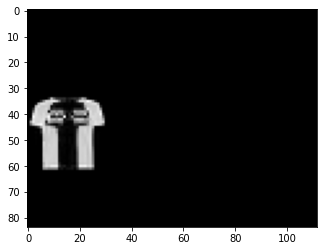

In [5]:
# print shapes
print(gt_train_02346.shape)
print(image_train_02346.shape)

# print info
plt.imshow(image_train_02346[1][0], cmap='gray')

In [6]:
# define dataset
dataset_train_02346 = ProductLineDataset(image_train_02346, gt_train_02346)
dataset_test_02346 = ProductLineDataset(image_test_02346, gt_test_02346)
dataset_test_579 = ProductLineDataset(image_test_579, gt_test_579)
dataset_test_18 = ProductLineDataset(image_test_18, gt_test_18)

# define dataloader
dataloader_train_02346 = DataLoader(dataset_train_02346, batch_size=512, shuffle=True)
dataloader_test_02346 = DataLoader(dataset_test_02346, batch_size=1, shuffle=True)  # batch_size=1 for accuracy calculation
dataloader_test_579 = DataLoader(dataset_test_579, batch_size=1, shuffle=True)
dataloader_test_18 = DataLoader(dataset_test_18, batch_size=1, shuffle=True)

In [7]:
# visualize the shape
for X, y in dataloader_train_02346:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape)
    print("Data type of y: ", y.dtype)
    print(y)
    break

Shape of X [N, C, H, W]:  torch.Size([512, 1, 84, 112])
Shape of y:  torch.Size([512, 2])
Data type of y:  torch.float32
tensor([[5., 0.],
        [4., 0.],
        [5., 0.],
        ...,
        [4., 0.],
        [3., 0.],
        [6., 0.]])


### Define functions

In [8]:
# define functions 
def train(model, dataloader_train, loss_fn, optimizer):   # put epoch in main better for loss calculation
    # initialize training loss
    train_loss = 0
    
    # size of dataset
    size = len(dataloader_train.dataset)
    
    # set model mode
    model.train()
    
    # train batches per epoch
    for batch, (X, y) in enumerate(dataloader_train):
        # move data to device
        X, y = X.to(device), y.to(device)
        
        score = model(X)
        # loss = torch.sum(torch.pow((score-y), 2) * torch.tensor([0.7, 0.3]).to(device)) / len(score)
        loss = loss_fn(score, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    # calculate the average loss and accuracy
    train_loss /= batch
    print(f"Avg training loss: {train_loss:>8f}")
            
    return train_loss
            
def test(model, dataloader, loss_fn):
    # size of dataset
    size = len(dataloader.dataset)
    
    # number of batches
    num_batches = len(dataloader)
    
    # set model mode
    model.eval()
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X,y in dataloader:
            # move data to device
            X, y = X.to(device), y.to(device)
            
            score = model(X)
            # test_loss += (torch.sum(torch.pow((score-y), 2) * torch.tensor([0.7, 0.3]).to(device)) / len(score)).item()
            test_loss += loss_fn(score, y).item()
            correct += 1 - abs(round(score[0][0].item()) - y[0][0].item()) / y[0][0].item()    # only for batch_size=1
    
    # calculate the average loss and accuracy
    test_loss /= num_batches
    correct /= num_batches
    print(f"Avg testing loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}%")
    
    return test_loss 

### FCN model setup and train/test

In [17]:
in_channel = (28*3)*(28*4)
node_1 = 1024
node_2 = 1024
node_3 = 512
node_4 = 256
node_5 = 64
node_6 = 8
out_channel = 2

FCN_model = FCN(in_channel, node_1, node_2, node_3, node_4, \
    node_5, node_6, out_channel).to(device=device)
print(FCN_model)

FCN(
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9408, out_features=1024, bias=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc4): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc5): Sequentia

In [18]:
# define parameters
learning_rate = 1e-3

# define lose function
loss_fn = nn.MSELoss()

# define optimizer
optimizer_FCN = torch.optim.Adam(FCN_model.parameters(), lr=learning_rate)

Epoch 1
-------------------------------
Avg training loss: 11.967213
Avg testing loss: 9.622572, Accuracy: 0.0%
Epoch 2
-------------------------------
Avg training loss: 11.098497
Avg testing loss: 7.832831, Accuracy: 7.3%
Epoch 3
-------------------------------
Avg training loss: 7.653305
Avg testing loss: 3.446514, Accuracy: 48.3%
Epoch 4
-------------------------------
Avg training loss: 1.756352
Avg testing loss: 0.994628, Accuracy: 67.6%
Epoch 5
-------------------------------
Avg training loss: 0.683968
Avg testing loss: 0.608766, Accuracy: 76.6%
Epoch 6
-------------------------------
Avg training loss: 0.554430
Avg testing loss: 0.560846, Accuracy: 76.8%
Epoch 7
-------------------------------
Avg training loss: 0.521652
Avg testing loss: 0.534435, Accuracy: 77.2%
Epoch 8
-------------------------------
Avg training loss: 0.506442
Avg testing loss: 0.544868, Accuracy: 77.1%
Epoch 9
-------------------------------
Avg training loss: 0.469760
Avg testing loss: 0.558079, Accuracy

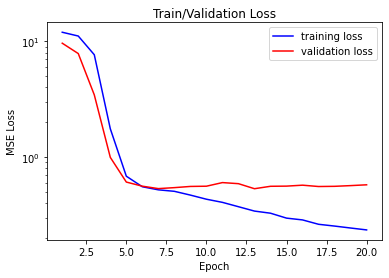

In [19]:
# set epoch
epoch = 20
loss_train = []
loss_val = []

# train epoch
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train.append(train(FCN_model, dataloader_train_02346, loss_fn, optimizer_FCN)) # train with loss record
    loss_val.append(test(FCN_model, dataloader_test_02346, loss_fn)) # test with loss record
print("Done!!")

# print loss
loss_train = np.array(loss_train).flatten() # transform to np.array and flatten
loss_val = np.array(loss_val).flatten()     # transform to np.array and flatten
x = range(1, epoch+1)
plt.semilogy(x, loss_train, 'b-', label="training loss")
plt.semilogy(x, loss_val, 'r-', label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train/Validation Loss")
plt.legend()
plt.show()


# model saving
torch.save(FCN_model.state_dict(), "FCN.pth")

### CNN model setup and train/test

In [14]:
in_channel = 1
channel_1 = 8
channel_2 = 16
channel_3 = 32
node_1 = 1024
node_2 = 1024
node_3 = 256
node_4 = 64
out_channel = 2

CNN_model = CNN(in_channel, channel_1, channel_2, channel_3, \
    node_1, node_2, node_3, node_4, out_channel).to(device=device)
print(CNN_model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4480, out_features=1024, bias=True)

In [15]:
# define parameters
learning_rate = 1e-3

# define lose function
loss_fn = nn.MSELoss()

# define optimizer
optimizer_CNN = torch.optim.Adam(CNN_model.parameters(), lr=learning_rate)

Epoch 1
-------------------------------
Avg training loss: 7.688664
Avg testing loss: 5.124039, Accuracy: 26.0%
Epoch 2
-------------------------------
Avg training loss: 1.322961
Avg testing loss: 1.723721, Accuracy: 71.1%
Epoch 3
-------------------------------
Avg training loss: 0.687685
Avg testing loss: 0.942189, Accuracy: 78.0%
Epoch 4
-------------------------------
Avg training loss: 0.449635
Avg testing loss: 0.855679, Accuracy: 78.9%
Epoch 5
-------------------------------
Avg training loss: 0.365578
Avg testing loss: 0.485184, Accuracy: 85.1%
Epoch 6
-------------------------------
Avg training loss: 0.326439
Avg testing loss: 0.417367, Accuracy: 85.4%
Epoch 7
-------------------------------
Avg training loss: 0.311022
Avg testing loss: 0.326909, Accuracy: 86.4%
Epoch 8
-------------------------------
Avg training loss: 0.284447
Avg testing loss: 0.281754, Accuracy: 84.2%
Epoch 9
-------------------------------
Avg training loss: 0.258147
Avg testing loss: 0.567088, Accuracy

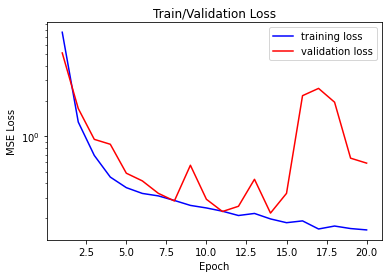

In [16]:
# set epoch
epoch = 20
loss_train = []
loss_val = []

# train epoch
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train.append(train(CNN_model, dataloader_train_02346, loss_fn, optimizer_CNN)) # train with loss record
    loss_val.append(test(CNN_model, dataloader_test_02346, loss_fn)) # test with loss record
print("Done!!")

# print loss
loss_train = np.array(loss_train).flatten() # transform to np.array and flatten
loss_val = np.array(loss_val).flatten()     # transform to np.array and flatten
x = range(1, epoch+1)
plt.semilogy(x, loss_train, 'b-', label="training loss")
plt.semilogy(x, loss_val, 'r-', label="validation loss")
# plt.plot(x, loss_train, 'b-', label="training loss")
# plt.plot(x, loss_val, 'r-', label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train/Validation Loss")
plt.legend()
plt.show()

# model saving
torch.save(CNN_model.state_dict(), "CNN.pth")

### Prediction visualization